# Import data and dependencies

In [ ]:
!pip install underthesea matplotlib==3.7.3 seaborn wordcloud jupyternotify

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import re   # biểu thức chính quy (regex)
import matplotlib.pyplot as plt
import seaborn as sns  # vẽ biểu đồ đẹp
import joblib # lưu model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # tìm hiểu pp TF-IDF
from sklearn.model_selection import cross_val_score # K-Fold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix # Đánh giá độ chính xác
from sklearn.naive_bayes import MultinomialNB # áp dụng phân phối đa thức
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from underthesea import text_normalize, word_tokenize
from wordcloud import WordCloud

No module named 'fasttext'


In [4]:
df = pd.read_csv('crawled.csv')
df.head()

,title,category
0,Dự luật thuế mới được Quốc hội phê chuẩn,Politics
1,Công ty công nghệ công bố lãi lớn kỷ lục,Business
2,Đội địa phương vô địch giải vô địch với trận c...,Sports
3,Chính sách giáo dục mới nhằm cải thiện tỷ lệ b...,Education
4,Mẹo giúp ngủ ngon và sức khỏe tinh thần tốt,Wellness


In [5]:
category_mapping = {
    'chính trị': 'Politics',
    'kinh doanh': 'Business',
    'thể thao': 'Sports',
    'giáo dục': 'Education',
    'sức khỏe': 'Wellness',
    'giải trí': 'Entertainment'
}
df['category'] = df['category'].map(category_mapping)
df.head()
df.to_csv('crawled1.csv', index=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     48 non-null     object
 1   category  48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


# Pre-processing

## Drop 'link' column and encode the label

In [6]:
category_mapping = {
    'Politics': 0,
    'Business': 1,
    'Sports': 2,
    'Education': 3,
    'Wellness': 4,
    'Entertainment': 5
}

#df.drop(columns=['link'], inplace=True)

df['category'] = df['category'].map(category_mapping)

df.head()

,title,category
0,Dự luật thuế mới được Quốc hội phê chuẩn,0
1,Công ty công nghệ công bố lãi lớn kỷ lục,1
2,Đội địa phương vô địch giải vô địch với trận c...,2
3,Chính sách giáo dục mới nhằm cải thiện tỷ lệ b...,3
4,Mẹo giúp ngủ ngon và sức khỏe tinh thần tốt,4


## Unicode normalization

In [7]:
import unicodedata

def unicode_normalize(text):
    return unicodedata.normalize('NFC', text) 
    #Chuyển đổi các ký tự tổ hợp thành các ký tự dựng sẵn tương ứng trong unicode

df['title'] = df['title'].apply(unicode_normalize)

df.head()

,title,category
0,Dự luật thuế mới được Quốc hội phê chuẩn,0
1,Công ty công nghệ công bố lãi lớn kỷ lục,1
2,Đội địa phương vô địch giải vô địch với trận c...,2
3,Chính sách giáo dục mới nhằm cải thiện tỷ lệ b...,3
4,Mẹo giúp ngủ ngon và sức khỏe tinh thần tốt,4


## Remove special characters and numbers

In [8]:
def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text) #Thay thế những kí tự trong pattern thành chuỗi rỗng
    return cleaned_text

df['title'] = df['title'].apply(clean_text)

df.head()

,title,category
0,Dự luật thuế mới được Quốc hội phê chuẩn,0
1,Công ty công nghệ công bố lãi lớn kỷ lục,1
2,Đội địa phương vô địch giải vô địch với trận c...,2
3,Chính sách giáo dục mới nhằm cải thiện tỷ lệ b...,3
4,Mẹo giúp ngủ ngon và sức khỏe tinh thần tốt,4


## Spelling normalization

In [9]:
def spelling_normalize(text):
    text = text.replace('kĩ','kỹ').replace('mỳ', 'mì').replace('sỹ', 'sĩ').replace('lí ',' lý ')

    return text

df['title'] = df['title'].apply(spelling_normalize).apply(text_normalize)

df.head()

,title,category
0,Dự luật thuế mới được Quốc hội phê chuẩn,0
1,Công ty công nghệ công bố lãi lớn kỷ lục,1
2,Đội địa phương vô địch giải vô địch với trận c...,2
3,Chính sách giáo dục mới nhằm cải thiện tỷ lệ b...,3
4,Mẹo giúp ngủ ngon và sức khỏe tinh thần tốt,4


## Tokenization

In [10]:
%%notify
tkn_df = df.copy()

tkn_df['title'] = tkn_df['title'].apply(lambda sentence: word_tokenize(sentence, format='text'))
# Hàm lambda này sử dụng word_tokenize để tách câu thành các từ riêng biệt. Thay thế dấu khoảng trắng trong từ phức thành dấu _
tkn_df.head()

,title,category
0,Dự_luật thuế mới được Quốc_hội phê_chuẩn,0
1,Công_ty công_nghệ công_bố lãi lớn kỷ_lục,1
2,Đội địa_phương vô_địch giải vô_địch với trận c...,2
3,Chính_sách giáo_dục mới nhằm cải_thiện tỷ_lệ b...,3
4,Mẹo giúp ngủ ngon và sức_khỏe tinh_thần tốt,4


<IPython.core.display.Javascript object>

## Capitalization (lower case)
# Capitalization (lower case) là quá trình chuyển đổi tất cả các chữ cái trong một đoạn văn bản thành chữ thường

In [11]:
tkn_df['title'] = tkn_df['title'].str.lower()
tkn_df.head()

,title,category
0,dự_luật thuế mới được quốc_hội phê_chuẩn,0
1,công_ty công_nghệ công_bố lãi lớn kỷ_lục,1
2,đội địa_phương vô_địch giải vô_địch với trận c...,2
3,chính_sách giáo_dục mới nhằm cải_thiện tỷ_lệ b...,3
4,mẹo giúp ngủ ngon và sức_khỏe tinh_thần tốt,4


## Stopwords

In [12]:
with open('stopwords.txt', 'r', encoding='utf-8') as file: 
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords] # Lấy các từ trong stopword ra
print(stopwords)

['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc', 'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của', 'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều', 'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'hơn', 'ít', 'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một', 'một_cách', 'này', 'nên', 'nếu', 'ngay', 'nhất', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'ở', 'phải', 'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ', 'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trong', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'về', 'vì', 'việc', 'với', 'vừa']


## Remove stopwords

In [13]:
def remove_stopwords(text): 
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

tkn_df['title'] = tkn_df['title'].apply(remove_stopwords) # loại những từ có trong file stopwords.txt 
tkn_df.head()

,title,category
0,dự_luật thuế mới quốc_hội phê_chuẩn,0
1,công_ty công_nghệ công_bố lãi lớn kỷ_lục,1
2,đội địa_phương vô_địch giải vô_địch trận chung...,2
3,chính_sách giáo_dục mới nhằm cải_thiện tỷ_lệ b...,3
4,mẹo giúp ngủ ngon sức_khỏe tinh_thần tốt,4


# Exploratory Data Analysis

## Numbers of articles by category

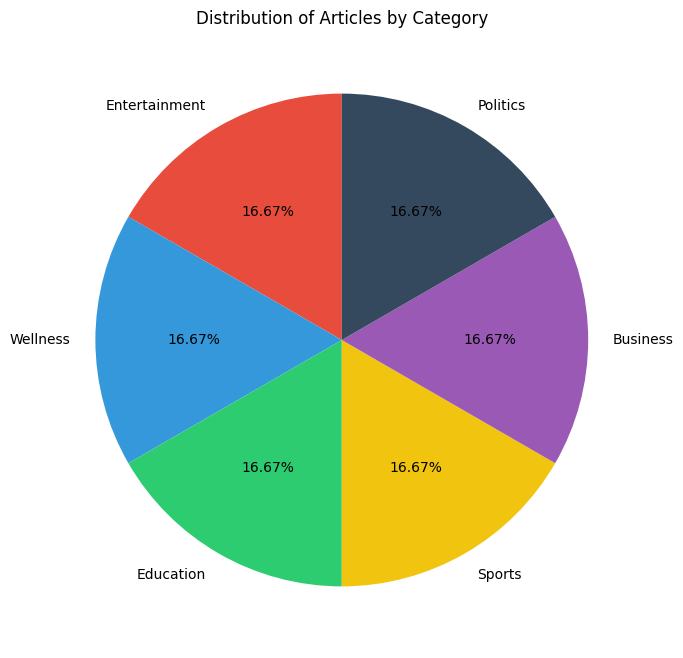

In [14]:
temp = pd.read_csv('crawled.csv')

category_order = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']
custom_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6', '#34495E']

# Tính số lượng bài viết trong mỗi danh mục và sắp xếp theo thứ tự định nghĩa
category_counts = temp['category'].value_counts().loc[category_order[::-1]]

# Tạo biểu đồ
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.2f%%', startangle=90, colors=custom_colors)
plt.title('Distribution of Articles by Category')

plt.show()

## Average sentence length

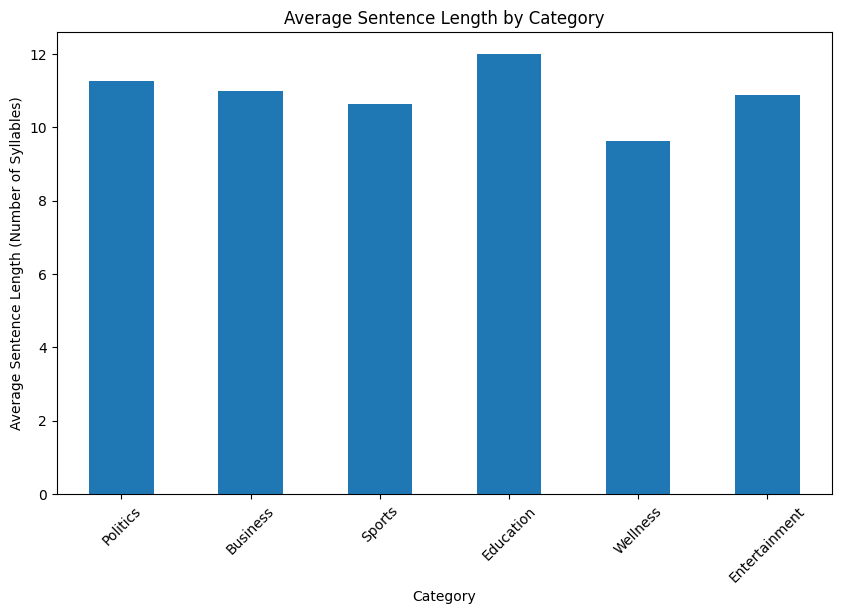

In [16]:
temp = pd.read_csv('crawled.csv')

category_order = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']

temp['sentence_length'] = temp['title'].apply(lambda x: len(x.split())) 
# Tính số lượng từ có trong 1 tiêu đề và lưu giá trị vào cột sentence_length

average_sentence_length = temp.groupby('category')['sentence_length'].mean().reindex(category_order)

plt.figure(figsize=(10, 6))
average_sentence_length.plot(kind='bar')
plt.title('Average Sentence Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentence Length (Number of Syllables)')
plt.xticks(rotation=45)
plt.show()

## Word clouds (Most popular words by category)

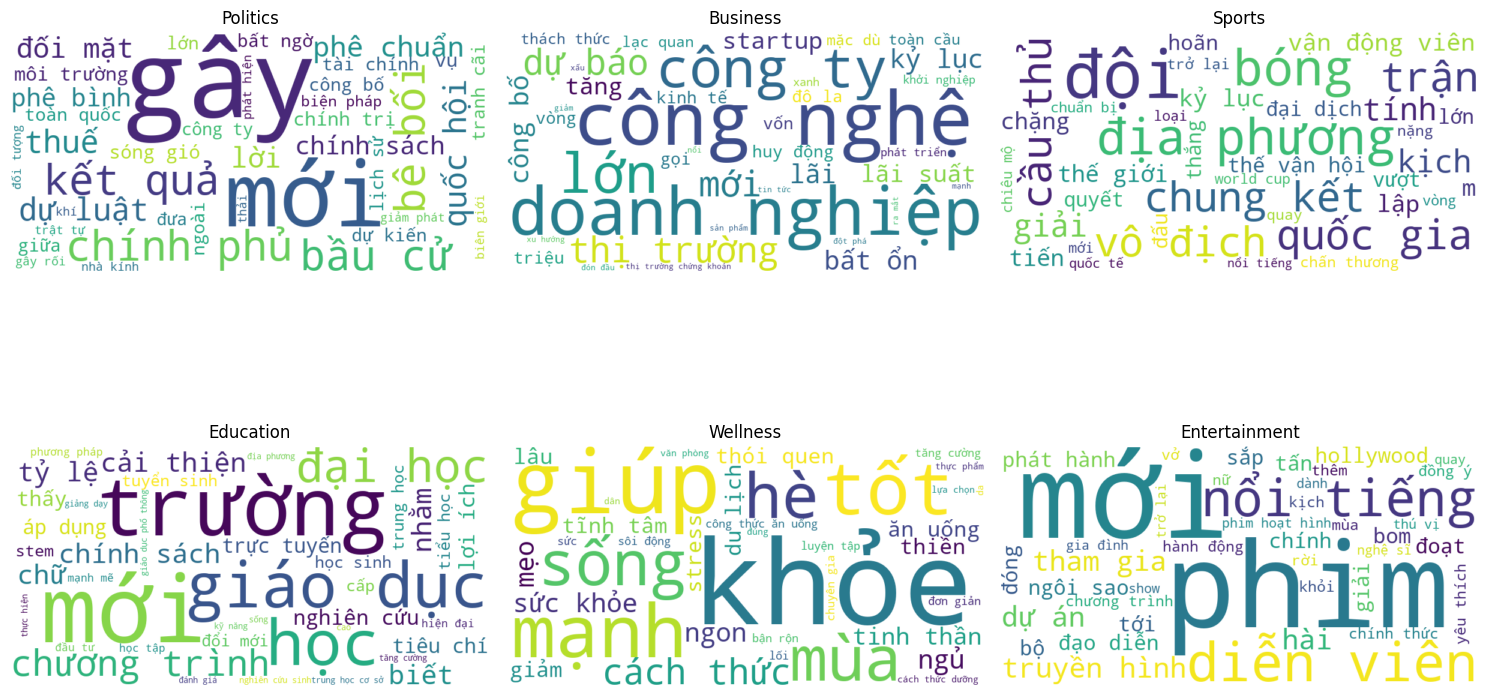

In [17]:
from collections import Counter

temp_tkn_df = tkn_df.copy()

temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])
# Tách từ cuả 1 tiêu đề dựa trên khoảng trắng vào mảng. Sau đó mới thay thế

category_names = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']
wordclouds = []

for category in range(6):
    category_data = temp_tkn_df[temp_tkn_df['category'] == category] # True thì trả về những hàng dữ liệu có cùng category

    all_titles = [item for sublist in category_data['title'] for item in sublist]
    # Gom các cụm từ theo category zô từng mảng

    word_counts = Counter(all_titles)
    # Thống kê các cụm từ trên

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    # từ xuất hiện nhiều thì làm cho nó to
    wordclouds.append(wordcloud)
plt.figure(figsize=(15, 10))

for i, wordcloud in enumerate(wordclouds):
    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(category_names[i])

plt.tight_layout()
plt.show()

## Words with highest and lowest frequency in the data set

In [18]:
temp_tkn_df = tkn_df.copy()

temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

all_words = [word for title in temp_tkn_df['title'] for word in title]

word_frequency = {}

total_titles = len(temp_tkn_df) 
# số lượng tilte

for word in all_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1
# Đếm số lần từ đó xuất hiện trong bảng dữ liệu

word_frequencies = {word: freq / total_titles for word, freq in word_frequency.items()}
# tần suất xuất hiện của các từ
word_frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)
word_frequency_df = word_frequency_df.reset_index(drop=True)
word_frequency_df.head(10)

,Word,Frequency
0,mới,0.250000
1,đội,0.125000
2,khỏe,0.083333
3,lớn,0.083333
4,địa phương,0.083333
5,nổi tiếng,0.083333
6,công nghệ,0.062500
7,sống,0.062500
8,mùa,0.062500
9,chương trình,0.062500


As we can see, there is no word whose frequency greater than 10%. Thus, we don't have any 'corpus-specific' stopwords in the dataset.

In [19]:
word_frequency_df.tail(10)

,Word,Frequency
203,đô la,0.020833
204,gọi,0.020833
205,vốn,0.020833
206,tiến,0.020833
207,áp dụng,0.020833
208,tiêu chí,0.020833
209,tuyển sinh,0.020833
210,du lịch,0.020833
211,thiền,0.020833
212,show,0.020833


There's a lot of rare and weird words showing here.

## Zipf's Law distribution

In [20]:
threshold_indices = [word_frequency_df[word_frequency_df['Frequency'] < (x/59958)].index[0] for x in [5, 10, 20]]
# Lấy chỉ số đầu tiên thoả mãn ngưỡng yêu cầu
threshold_colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 6))
plt.plot(word_frequency_df.index, word_frequency_df['Frequency'], linestyle='-')

for threshold_index, threshold_color, threshold_value in zip(threshold_indices, threshold_colors, [5, 10, 20]):
    plt.axvline(x=threshold_index, color=threshold_color, linestyle='--', label=f'{threshold_value} articles threshold')

plt.title('Word Frequency vs. Rank')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

# Feature extraction (TF-IDF)
# xem https://youtu.be/vZAXpvHhQow?si=pO0zsFqkmxpmiiaP
# Phương pháp TF-IDF (Term Frequency-Inverse Document Frequency) là một kỹ thuật quan trọng trong xử lý ngôn ngữ tự nhiên và phân tích văn bản để đánh giá mức độ quan trọng của một từ trong một tài liệu, dựa trên sự xuất hiện của từ đó trong tài liệu cụ thể và trong toàn bộ tập dữ liệu.

In [21]:
corpus = tkn_df.copy()
corpus['title'] = corpus['title'].astype(str)
# chuyển kiểu dữ liệu của title thành str

In [32]:
tkn_df.head(10)

,title,category
0,dự_luật thuế mới quốc_hội phê_chuẩn,0
1,công_ty công_nghệ công_bố lãi lớn kỷ_lục,1
2,đội địa_phương vô_địch giải vô_địch trận chung...,2
3,chính_sách giáo_dục mới nhằm cải_thiện tỷ_lệ b...,3
4,mẹo giúp ngủ ngon sức_khỏe tinh_thần tốt,4
5,ngôi_sao hollywood đóng chính bom tấn sắp tới,5
6,chính_phủ đối_mặt lời phê_bình chính_sách môi_...,0
7,thị_trường dự_báo bất_ổn lãi_suất tăng,1
8,vận_động_viên lập kỷ_lục thế_giới chặng m,2
9,nghiên_cứu mới thấy lợi_ích học trực_tuyến,3


We removed rare words (and weird words caused by tokenizer) which are shown in less than 10 articles by setting the parameter min_df=10 to limit the vocabulary size. This will avoid overfitting and tremendously reduce computational cost later on.

In [29]:
vectorizer = TfidfVectorizer(min_df=2)
# nhầm loại bỏ các từ có tầng suất nhỏ hơn 10
features = vectorizer.fit_transform(corpus['title'])
print(features)
joblib.dump(vectorizer, 'models/tfidf.joblib')
# lưu trữ model

tfidf_df = pd.DataFrame(data=features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df['category'] = corpus['category']
tfidf_df.to_excel('crawled2.xlsx', index=False)
tfidf_df.head()

  (0, 31)	1.0
  (1, 27)	0.4736764067549587
  (1, 28)	0.4098871167024482
  (1, 8)	0.4736764067549587
  (1, 9)	0.43775214158743725
  (1, 10)	0.43775214158743725
  (2, 26)	0.4322589691034798
  (2, 3)	0.4322589691034798
  (2, 41)	0.4322589691034798
  (2, 18)	0.4322589691034798
  (2, 47)	0.37404730315448237
  (2, 48)	0.3357042590156498
  (3, 16)	0.6487085158467085
  (3, 5)	0.6487085158467085
  (3, 31)	0.39793783802991317
  (4, 44)	0.7344073797929055
  (4, 17)	0.6787089217814357
  (6, 4)	0.7071067811865475
  (6, 5)	0.7071067811865475
  (7, 14)	0.7071067811865475
  (7, 38)	0.7071067811865475
  (8, 27)	1.0
  (9, 23)	0.8524007979016592
  (9, 31)	0.5228889745793219
  (10, 36)	0.5078863391924475
  :	:
  (38, 48)	0.4176854536242705
  (39, 6)	0.5615793126049676
  (39, 40)	0.5615793126049676
  (39, 23)	0.6076654929385609
  (40, 22)	0.5919264570704938
  (40, 29)	0.5470339466979592
  (40, 44)	0.5919264570704938
  (41, 15)	1.0
  (43, 13)	0.6188115288948647
  (43, 38)	0.6695944887956975
  (43, 31)	0.410

,bê_bối,bóng,bầu_cử,chung_kết,chính_phủ,chính_sách,chương_trình,cách_thức,công_bố,công_nghệ,...,trường,trận,trở_lại,tăng_cường,tốt,vòng,đại_học,địa_phương,đội,category
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.473676,0.437752,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1
2,0.0,0.0,0.0,0.432259,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.432259,0.0,0.0,0.000000,0.0,0.0,0.374047,0.335704,2
3,0.0,0.0,0.0,0.000000,0.0,0.648709,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,3
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.734407,0.0,0.0,0.000000,0.000000,4


Number of features reduces to 4759 from 32437

# Data splitting

In [ ]:
# train_df, temp_df = train_test_split(tfidf_df, test_size=0.2, stratify=tfidf_df['category'], random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)

# train_df.to_csv('df/train_df.csv', index=False)
# val_df.to_csv('df/val_df.csv', index=False)
# test_df.to_csv('df/test_df.csv', index=False)

# Hyperparameter tuning

In [70]:
%%notify
train_df = pd.read_csv('df/train_df.csv')
val_df = pd.read_csv('df/val_df.csv')
test_df = pd.read_csv('df/test_df.csv')

X_train = train_df.drop(columns=['category'])
y_train = train_df['category']

X_val = val_df.drop(columns=['category'])
y_val = val_df['category']

X_test = test_df.drop(columns=['category'])
y_test = test_df['category']

KeyError: "['category'] not found in axis"

<IPython.core.display.Javascript object>

## Naive Bayes
# https://youtu.be/km2LoOpdB3A?si=m7aygVjnPaGa_3An

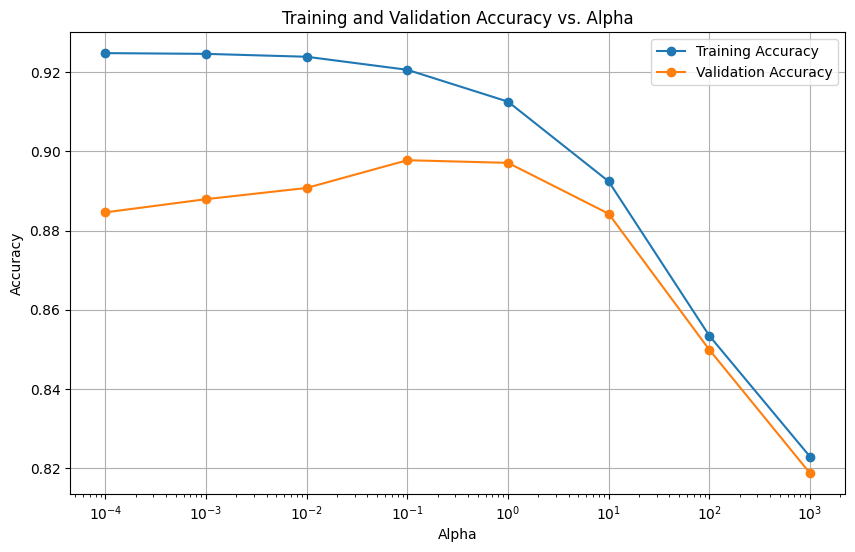

In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.grid(True)
plt.legend()
plt.show()

## k-Nearest Neighbors

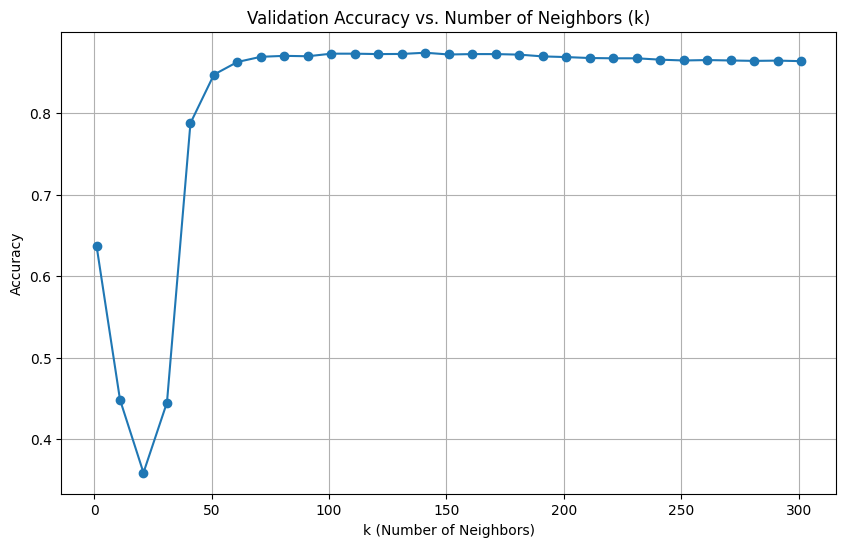

<IPython.core.display.Javascript object>

In [ ]:
%%notify
k_values = range(1, 302, 10)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()

In [ ]:
%%notify
param_grid = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

results = []

for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        with joblib.parallel_backend('loky'):
            clf = KNeighborsClassifier(n_neighbors=101, weights=weight, metric=metric, n_jobs=-1)

            clf.fit(X_train, y_train)

            y_val_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)

            results.append({
                'weights': weight,
                'distance_metric': metric,
                'accuracy': accuracy
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,weights,distance_metric,accuracy
0,distance,cosine,0.880754
1,uniform,cosine,0.876084
2,uniform,euclidean,0.872748
3,distance,euclidean,0.870247
4,uniform,manhattan,0.576718
5,distance,manhattan,0.567045


<IPython.core.display.Javascript object>

## Logistic Regression
# https://youtu.be/PVM7P6qXz-4?si=Qo68yeLx58TfCSCY
# tìm hiểu thêm ở các video liên quan

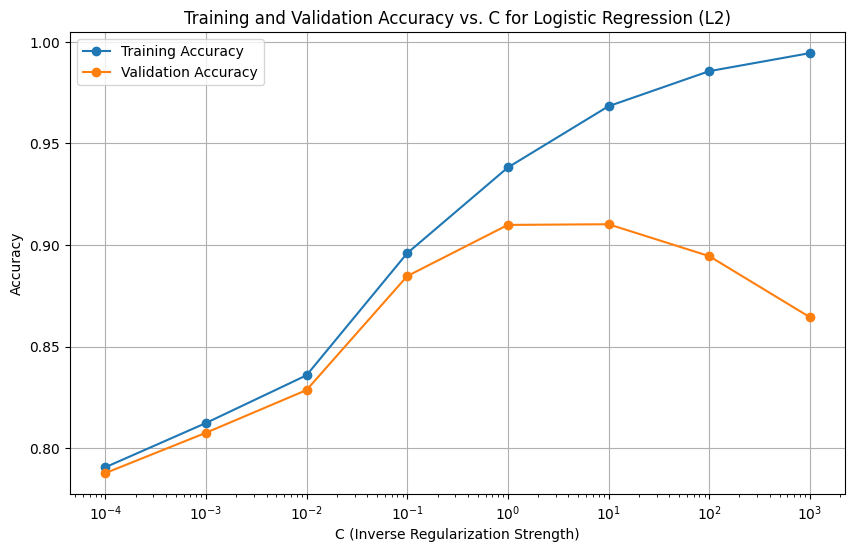

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    with joblib.parallel_backend('loky'):
        clf = LogisticRegression(C=C, max_iter=10000, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Logistic Regression (L2)')
plt.grid(True)
plt.legend()
plt.show()

## Support Vector Machine
# https://youtu.be/RnapcMi9lqA?si=_OHrvHCNRKMlBexE 
# xem 3 video 24,25,26

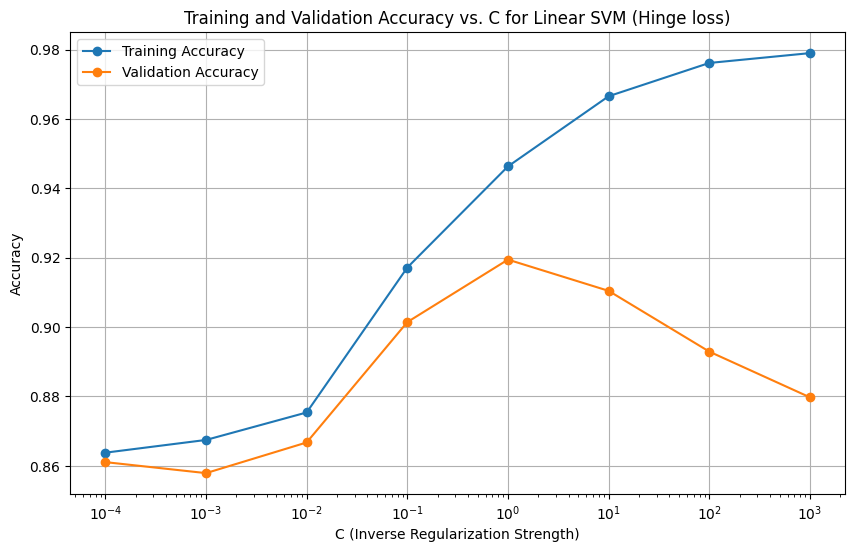

<IPython.core.display.Javascript object>

In [ ]:
%%notify
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    clf = LinearSVC(C=C, loss='hinge', max_iter=10000)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Linear SVM (Hinge loss)')
plt.grid(True)
plt.legend()
plt.show()

## Random Forest

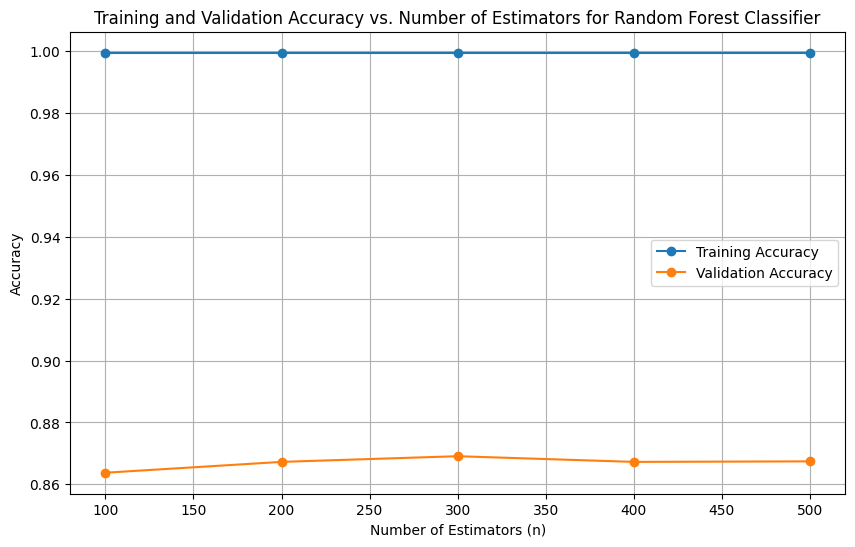

<IPython.core.display.Javascript object>

In [ ]:
%%notify
n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

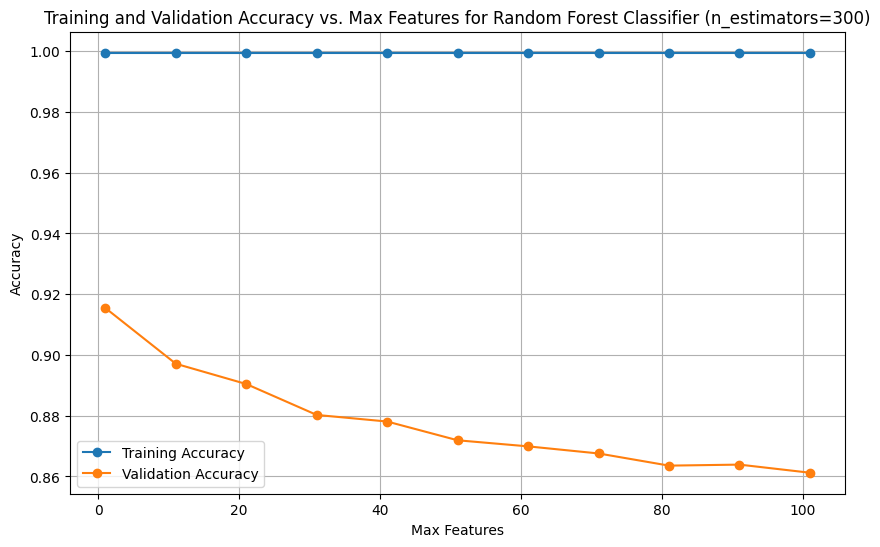

<IPython.core.display.Javascript object>

In [ ]:
%%notify
max_features_values = range(1, 102, 10)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=max_features, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_features_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Random Forest Classifier (n_estimators=300)')
plt.grid(True)
plt.legend()
plt.show()

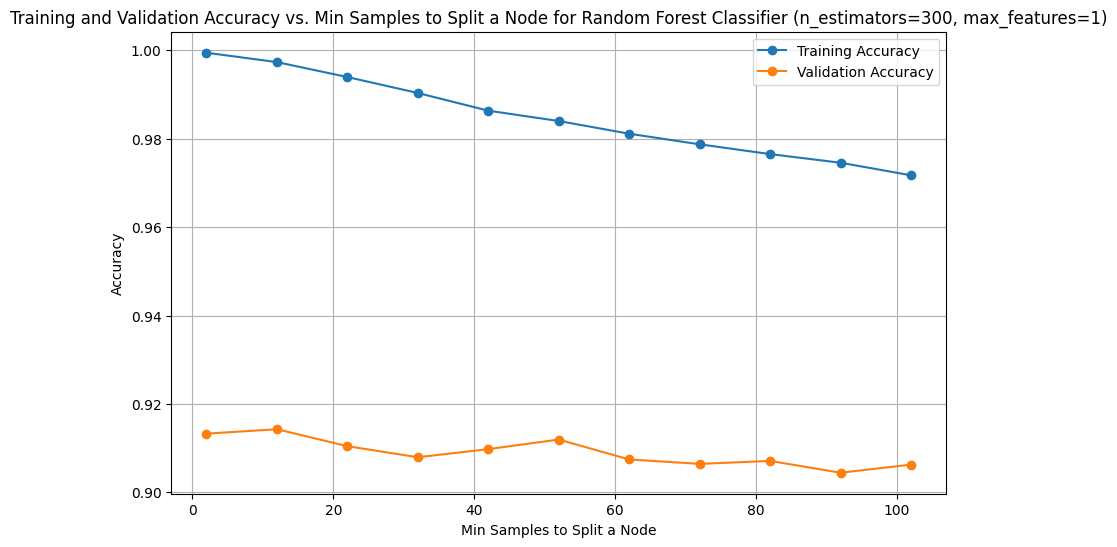

<IPython.core.display.Javascript object>

In [ ]:
%%notify
min_samples_split_values = range(2, 103, 10)
train_accuracies = []
validation_accuracies = []

for min_samples_split in min_samples_split_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=min_samples_split, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(min_samples_split_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Min Samples to Split a Node')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Min Samples to Split a Node for Random Forest Classifier (n_estimators=300, max_features=1)')
plt.grid(True)
plt.legend()
plt.show()

# Model testing

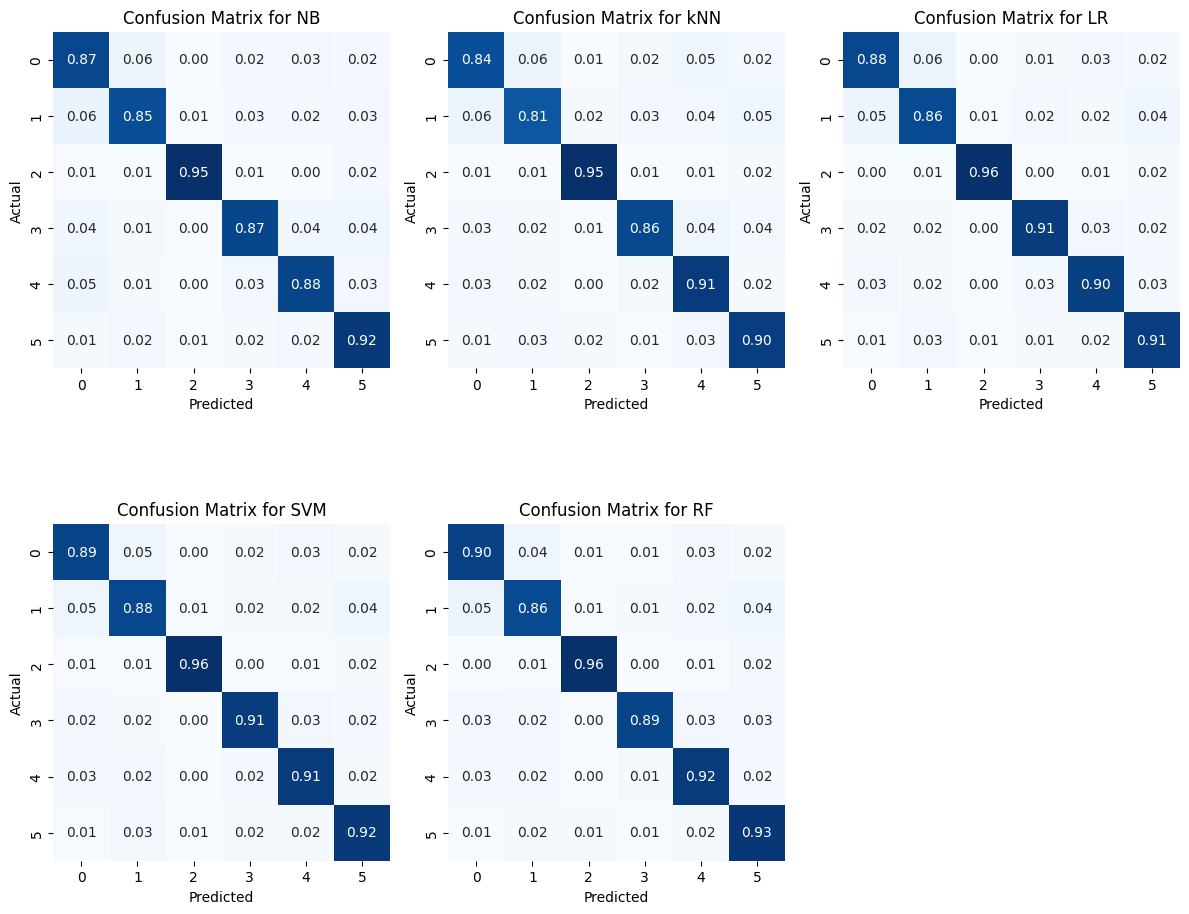

,Accuracy,Training Time (s),Testing Time (s)
NB,88.99%,0.42,0.06
kNN,87.88%,0.17,51.62
LR,90.36%,255.75,0.07
SVM,91.01%,3.28,0.06
RF,91.11%,37.36,2.81


<IPython.core.display.Javascript object>

In [ ]:
%%notify
import time

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf2 = LogisticRegression(C=10, max_iter=10000, n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'LR', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []

for i, clf in enumerate(classifiers):
    with joblib.parallel_backend('loky'):
        start_time1 = time.time()
        clf.fit(X_train, y_train)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        start_time2 =time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = end_time2 - start_time2
        testing_times.append(testing_time)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

#         model_filename = f'models/clf{i}.joblib'
#         joblib.dump(clf, model_filename)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
                'Training Time (s)': [f'{time:.2f}' for time in training_times],
                'Testing Time (s)': [f'{time:.2f}' for time in testing_times]}
display(pd.DataFrame(test_results, index=classifier_labels))